# Probabilistic Forecasting with `sktime`

originally presented at [pydata Berlin 2022, see there for video presentation](https://github.com/sktime/sktime-tutorial-pydata-berlin-2022)

### Overview of this notebook

* quick start - probabilistic forecasting
* disambiguation - types of probabilistic forecasts
* details: probabilistic forecasting interfaces
* metrics for, and evaluation of probabilistic forecasts
* advanced composition: pipelines, tuning, reduction
* extender guide
* contributor credits

In [2]:
import warnings

warnings.filterwarnings("ignore")

---
### Quick Start - Probabilistic Forecasting with `sktime`

... works exactly like the basic forecasting workflow, replace `predict` by a probabilistic method!

In [3]:
from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA

# step 1: data specification
y = load_airline()
# step 2: specifying forecasting horizon
fh = [1, 2, 3]
# step 3: specifying the forecasting algorithm
forecaster = ARIMA()
# step 4: fitting the forecaster
forecaster.fit(y, fh=[1, 2, 3])
# step 5: querying predictions
y_pred = forecaster.predict()

# for probabilistic forecasting:
#   call a probabilistic forecasting method after or instead of step 5
y_pred_int = forecaster.predict_interval(coverage=0.9)
y_pred_int

Number of airline passengers            
                                 0.9            
                               lower       upper
1961-01                   371.535093  481.554608
1961-02                   344.853205  497.712761
1961-03                   324.223995  508.191104

**probabilistic forecasting methods in `sktime`**:

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* forecast variance     - `predict_var(fh=None, X=None, cov=False)`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

To check which forecasters in `sktime` support probabilistic forecasting, use the `registry.all_estimators` utility and search for estimators which have the `capability:pred_int` tag (value `True`).

For composites such as pipelines, a positive tag means that logic is implemented if (some or all) components support it.

In [4]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster", filter_tags={"capability:pred_int": True}, as_dataframe=True
)

,name,object
0,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
1,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
2,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
3,BATS,<class 'sktime.forecasting.bats.BATS'>
4,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
5,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
6,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
7,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
8,FhPlexForecaster,<class 'sktime.forecasting.compose._fhplex.FhP...
9,ForecastX,<class 'sktime.forecasting.compose._pipeline.F...


---
### What is probabilistic forecasting?

#### Intuition

* produce low/high scenarios of forecasts
* quantify uncertainty around forecasts
* produce expected range of variation of forecasts

#### Interface view

**Want** to produce "distribution" or "range" of forecast values,

at time stamps defined by **forecasting horizon** `fh`

given **past data** `y` (series), and possibly exogeneous data `X`

Input, to `fit` or `predict`: `fh`, `y`, `X`

Output, from `predict_probabilistic`: some "distribution" or "range" object

**Big caveat**: there are multiple possible ways to model "distribution" or "range"!

Used in practice and easily confused! (and often, practically, confused!)

#### Formal view (endogeneous, one forecast time stamp)

Let  $y(t_1), \dots, y(t_n)$ be observations at fixed time stamps $t_1, \dots, t_n$. 

(we consider $y$ as an $\mathbb{R}^n$-valued random variable)

Let $y'$ be a (true) value, which will be observed at a future time stamp $\tau$.

(we consider $y'$ as an $\mathbb{R}$-valued random variable)

We have the following "types of forecasts" of $y'$:

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

Notes:

* different forecasters have different capabilities!
* metrics, evaluation & tuning are different by "type of forecast"
* compositors can "add" type of forecast! Example: bootstrap

##### More formal details & intuition:

* a **"point forecast"** is a prediction/estimate of the conditional expectation $\mathbb{E}[y'|y]$.\
 **Intuition**: "out of many repetitions/worlds, this value is the arithmetic average of all observations".
* a **"variance forecast"** is a prediction/estimate of the conditional expectation $Var[y'|y]$.\
 **Intuition:** "out of many repetitions/worlds, this value is the average squared distance of the observation to the perfect point forecast".
* a **"quantile forecast"**, at quantile point $\alpha\in (0,1)$ is a prediction/estimate of the $\alpha$-quantile of $y'|y$, i.e., of $F^{-1}_{y'|y}(\alpha)$, where $F^{-1}$ is the (generalized) inverse cdf = quantile function of the random variable y'|y.\
 **Intuition**: "out of many repetitions/worlds, a fraction of exactly $\alpha$ will have equal or smaller than this value."
* an **"interval forecast"** or "predictive interval" with (symmetric) coverage $c\in (0,1)$ is a prediction/estimate pair of lower bound $a$ and upper bound $b$ such that $P(a\le y' \le b| y) = c$ and $P(y' \gneq b| y) = P(y' \lneq a| y) = (1 - c) /2$.\
 **Intuition**: "out of many repetitions/worlds, a fraction of exactly $c$ will be contained in the interval $[a,b]$, and being above is equally likely as being below".
* a **"distribution forecast"** or "full probabilistic forecast" is a prediction/estimate of the distribution of $y'|y$, e.g., "it's a normal distribution with mean 42 and variance 1".\
**Intuition**: exhaustive description of the generating mechanism of many repetitions/worlds.

Notes:

* lower/upper of interval forecasts are quantile forecasts at quantile points $0.5 - c/2$ and $0.5 + c/2$ (as long as forecast distributions are absolutely continuous).
* all other forecasts can be obtained from a full probabilistic forecasts; a full probabilistic forecast can be obtained from all quantile forecasts or all interval forecasts.
* there is no exact relation between the other types of forecasts (point or variance vs quantile)
* in particular, point forecast does not need to be median forecast aka 0.5-quantile forecast. Can be $\alpha$-quantile for any $\alpha$!

Frequent confusion in literature & python packages:
* coverage `c` vs quantile `\alpha`
* coverage `c` vs significance `p = 1-c`
* quantile of lower interval bound, `p/2`, vs `p`
* interval forecasts vs related, but substantially different concepts: confidence interval on predictive mean; Bayesian posterior or credibility interval of the predictive mean
* all forecasts above can be Bayesian, confusion: "posteriors are different" or "have to be evaluted differently"

---
### Probabilistic forecasting interfaces in `sktime` 

This section:

* walkthrough of probabilistic predict methods
* use in update/predict workflow
* multivariate and hierarchical data

All forecasters with tag `capability:pred_int` provide the following:

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* forecast variance     - `predict_var(fh=None, X=None, cov=False)`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

Generalities:

* methods do not change state, multiple can be called
* `fh` is optional, if passed late
* exogeneous data `X` can be passed

In [5]:
import numpy as np

from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

# until fit, identical with the simple workflow
y = load_airline()

fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, fh=fh)

ThetaForecaster(sp=12)

##### `predict_interval` - interval predictions

Inputs:\
`fh` - forecasting horizon (not necessary if seen in `fit`)\
`coverage`, float or list of floats, default=`0.9`\
nominal coverage(s) of the prediction interval(s) queried

Output: `pandas.DataFrame`\
Row index is `fh`\
Column has multi-index:\
1st level = variable name from y in fit\
2nd level = coverage fractions in `coverage`\
3rd level = string "lower" or "upper"\

Entries = forecasts of lower/upper interval at nominal coverage in 2nd lvl, for var in 1st lvl, for time in row

In [6]:
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Number of airline passengers            
                                 0.9            
                               lower       upper
1961-01                   418.280121  464.281951
1961-02                   402.215881  456.888055
1961-03                   459.966113  522.110500
1961-04                   442.589309  511.399214
1961-05                   443.525027  518.409480
1961-06                   506.585814  587.087737
1961-07                   561.496768  647.248956
1961-08                   557.363322  648.062363
1961-09                   477.658055  573.047752
1961-10                   407.915090  507.775355
1961-11                   346.942924  451.082017
1961-12                   394.708221  502.957142

pretty-plotting the predictive interval forecasts:

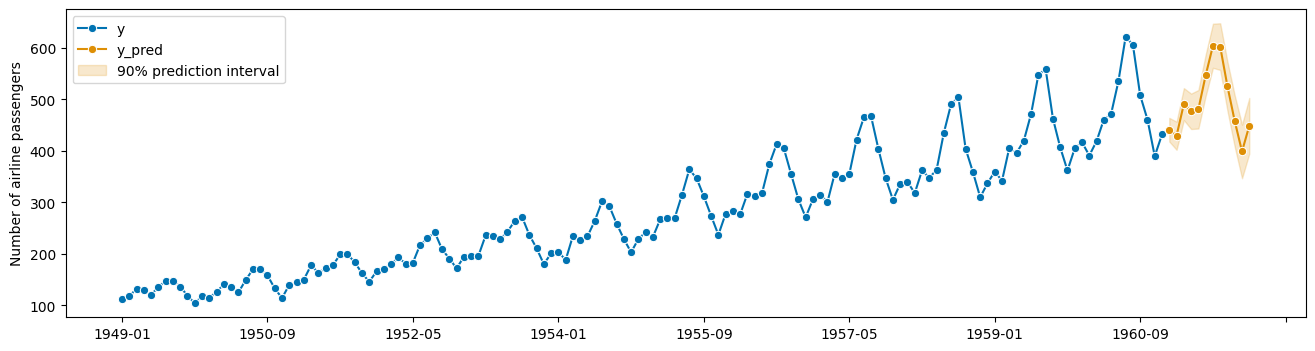

In [7]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(
    y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints
)

ax.legend();

multiple coverages:

In [8]:
coverage = [0.5, 0.9, 0.95]
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Number of airline passengers                                      \
                                0.50                    0.90               
                               lower       upper       lower       upper   
1961-01                   431.849266  450.712806  418.280121  464.281951   
1961-02                   418.342514  440.761421  402.215881  456.888055   
1961-03                   478.296822  503.779790  459.966113  522.110500   
1961-04                   462.886144  491.102379  442.589309  511.399214   
1961-05                   465.613670  496.320837  443.525027  518.409480   
1961-06                   530.331440  563.342111  506.585814  587.087737   
1961-07                   586.791063  621.954661  561.496768  647.248956   
1961-08                   584.116789  621.308897  557.363322  648.062363   
1961-09                   505.795123  544.910684  477.658055  573.047752   
1961-10                   437.370840  478.319605  407.915090  507.775355   
1961-11                   377.660798  420.364142  346.942924  451.082017   
1961-12                   426.638370  471.026993  394.708221  502.957142   

                                 
               0.95              
              lower       upper  
1961-01  413.873755  468.688317  
1961-02  396.979011  462.124925  
1961-03  454.013504  528.063109  
1961-04  435.998232  517.990291  
1961-05  436.352089  525.582418  
1961-06  498.874797  594.798754  
1961-07  553.282845  655.462879  
1961-08  548.675556  656.750129  
1961-09  468.520987  582.184821  
1961-10  398.349800  517.340645  
1961-11  336.967779  461.057162  
1961-12  384.339408  513.325954

##### `predict_quantiles` - quantile forecasts

Inputs:\
`fh` - forecasting horizon (not necessary if seen in `fit`)\
`alpha`, float or list of floats, default = `[0.1, 0.9]`\
quantile points at which quantiles are queried

Output: `pandas.DataFrame`\
Row index is `fh`\
Column has multi-index:\
1st level = variable name from y in fit\
2nd level = quantile points in `alpha`\

Entries = forecasts of quantiles at quantile point in 2nd lvl, for var in 1st lvl, for time in row

In [9]:
alpha = [0.1, 0.25, 0.5, 0.75, 0.9]
y_pred_quantiles = forecaster.predict_quantiles(alpha=alpha)
y_pred_quantiles

Number of airline passengers                                      \
                                0.10        0.25        0.50        0.75   
1961-01                   423.360378  431.849266  441.281036  450.712806   
1961-02                   408.253656  418.342514  429.551968  440.761421   
1961-03                   466.829089  478.296822  491.038306  503.779790   
1961-04                   450.188398  462.886144  476.994261  491.102379   
1961-05                   451.794965  465.613670  480.967253  496.320837   
1961-06                   515.476123  530.331440  546.836776  563.342111   
1961-07                   570.966895  586.791063  604.372862  621.954661   
1961-08                   567.379760  584.116789  602.712843  621.308897   
1961-09                   488.192511  505.795123  525.352904  544.910684   
1961-10                   418.943257  437.370840  457.845222  478.319605   
1961-11                   358.443627  377.660798  399.012470  420.364142   
1961-12                   406.662797  426.638370  448.832681  471.026993   

                     
               0.90  
1961-01  459.201694  
1961-02  450.850279  
1961-03  515.247523  
1961-04  503.800124  
1961-05  510.139542  
1961-06  578.197428  
1961-07  637.778829  
1961-08  638.045925  
1961-09  562.513297  
1961-10  496.747188  
1961-11  439.581313  
1961-12  491.002565

pretty-plotting the quantile interval forecasts:

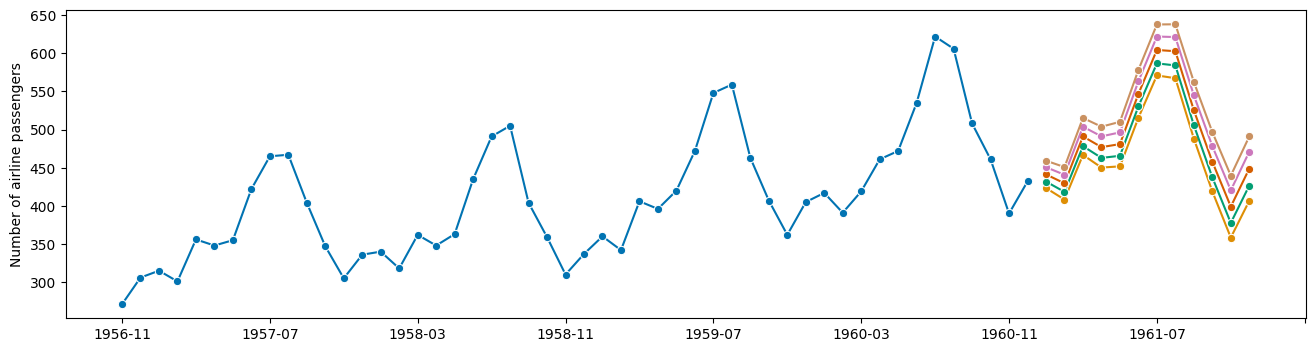

In [10]:
from sktime.utils import plotting

columns = [y_pred_quantiles[i] for i in y_pred_quantiles.columns]
fig, ax = plotting.plot_series(y[-50:], *columns)

##### `predict_var` - variance forecasts

Inputs:\
`fh` - forecasting horizon (not necessary if seen in `fit`)\
`cov`, boolean, default=False\
whether covariance forecasts should also be returned (not all estimators support this)

Output: `pandas.DataFrame`, for cov=False:\
Row index is `fh`\
Column is equal to column index of `y` (variables)

Entries = variance forecast for variable in col, for time in row

In [11]:
y_pred_variance = forecaster.predict_var()
y_pred_variance

,Number of airline passengers
1961-01,195.540049
1961-02,276.196510
1961-03,356.852970
1961-04,437.509430
1961-05,518.165890
1961-06,598.822350
1961-07,679.478810
1961-08,760.135270
1961-09,840.791730
1961-10,921.448190


with covariance, using a forecaster which can return covariance forecasts:

return is `pandas.DataFrame` with `fh` indexing rows and columns;\
entries are forecast covariance between row and column time\
(diagonal = forecast variances)

In [12]:
from sktime.forecasting.naive import NaiveVariance

forecaster_with_covariance = NaiveVariance(forecaster)
forecaster_with_covariance.fit(y=y, fh=fh)
forecaster_with_covariance.predict_var(cov=True)

,1961-01,1961-02,1961-03,1961-04,1961-05,1961-06,1961-07,1961-08,1961-09,1961-10,1961-11,1961-12
1961-01,292.337333,255.742991,264.805437,227.703049,146.093848,154.452828,157.976795,105.160767,78.330263,81.835807,78.048880,197.364510
1961-02,255.742991,422.704601,402.539255,353.437043,291.205404,236.587874,227.199374,205.653010,152.067425,121.629138,156.199110,245.437907
1961-03,264.805437,402.539255,588.085328,506.095455,426.997512,394.503923,311.457837,282.072145,243.688600,185.938840,185.070360,305.461211
1961-04,227.703049,353.437043,506.095455,634.350443,526.180879,482.653094,422.777303,323.453741,280.749312,242.065788,211.397164,294.971031
1961-05,146.093848,291.205404,426.997512,526.180879,628.659343,570.277520,499.460184,419.166444,325.582777,281.608605,269.847439,318.534675
1961-06,154.452828,236.587874,394.503923,482.653094,570.277520,728.132497,629.184840,527.767034,444.690518,330.643655,313.248426,382.803216
1961-07,157.976795,227.199374,311.457837,422.777303,499.460184,629.184840,753.550004,629.138725,536.407567,441.998605,352.570966,415.110916
1961-08,105.160767,205.653010,282.072145,323.453741,419.166444,527.767034,629.138725,729.423304,615.142491,506.155614,439.994838,430.992291
1961-09,78.330263,152.067425,243.688600,280.749312,325.582777,444.690518,536.407567,615.142491,744.225561,609.227140,527.489573,546.637585
1961-10,81.835807,121.629138,185.938840,242.065788,281.608605,330.643655,441.998605,506.155614,609.227140,697.805479,590.542043,604.681130


##### `predict_proba` - distribution forecasts aka "full" probabilistic forecasts

Inputs:\
`fh` - forecasting horizon (not necessary if seen in `fit`)\
`marginal`, bool, optional, default=True\
whether returned distribution is marginal over time points (True), or joint over time points (False)\
(not all forecasters support `marginal=False`)

Output: `tensorflow-probability` `Distribution` object (requires `tensorflow` installed)\
if `marginal=True`: batch shape 1D, `len(fh)` (time); event shape 1D, `len(y.columns)` (variables)\
if `marginal=False`: event shape 2D, `[len(fh), len(y.columns)]`

In [13]:
y_pred_dist = forecaster.predict_proba()
y_pred_dist

Normal(columns=Index(['Number of airline passengers'], dtype='object'),
       index=PeriodIndex(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12'],
            dtype='period[M]'),
       mu=         Number of airline passengers
1961-01                    441.281036
1961-02                    429.551968
1961-03                    491.038306
1961-04                    476.994261
1961-05                    480.967253
1961-06                    546.836776
1961-07                    604.372862
1961-08                    602.712843
1961-09                    525.352904
1961-10                    457.845222
1961-11                    399.012470
1961-12                    448.832681,
       sigma=         Number of airline passengers
1961-01                     13.983564
1961-02                     16.619161
1961-03                     18.890552
1961-04                     20.916726
1961-05                     22.763257
1961-06                     24.470847
1961-07                     26.066814
1961-08                     27.570551
1961-09                     28.996409
1961-10                     30.355365
1961-11                     31.656037
1961-12                     32.905336)

In [14]:
# obtaining quantiles
y_pred_dist.quantile([0.1, 0.9])

Number of airline passengers            
                                 0.1         0.9
1961-01                   423.360378  459.201694
1961-02                   408.253656  450.850279
1961-03                   466.829089  515.247523
1961-04                   450.188398  503.800124
1961-05                   451.794965  510.139542
1961-06                   515.476123  578.197428
1961-07                   570.966895  637.778829
1961-08                   567.379760  638.045925
1961-09                   488.192511  562.513297
1961-10                   418.943257  496.747188
1961-11                   358.443627  439.581313
1961-12                   406.662797  491.002565

##### a note on consistence of methods

Outputs of `predict_interval`, `predict_quantiles`, `predict_var`, `predict_proba` are *typically* but not *necessarily* consistent with each other!

Consistency is weak interface requirement but not strictly enforced.

#### Using probabilistic forecasts with update/predict stream workflow

Example:
* data observed monthly
* make probabilistic forecasts for an entire year ahead
* update forecasts every month
* start in Dec 1950

In [15]:
# 1949 and 1950
y_start = y[:24]
# Jan 1951 etc
y_update_batch_1 = y.loc[["1951-01"]]
y_update_batch_2 = y.loc[["1951-02"]]
y_update_batch_3 = y.loc[["1951-03"]]

In [16]:
# now = Dec 1950

# 1a. fit to data available in Dec 1950
#   fh = [1, 2, ..., 12] for all 12 months ahead
forecaster.fit(y_start, fh=1 + np.arange(12))

# 1b. predict 1951, in Dec 1950
forecaster.predict_interval()
# or other proba predict functions

Number of airline passengers            
                                 0.9            
                               lower       upper
1951-01                   125.708002  141.744261
1951-02                   135.554588  154.422393
1951-03                   149.921349  171.248013
1951-04                   140.807416  164.337377
1951-05                   127.941095  153.485009
1951-06                   152.968275  180.378566
1951-07                   167.193932  196.351377
1951-08                   166.316508  197.122174
1951-09                   150.425511  182.795583
1951-10                   128.623026  162.485306
1951-11                   109.567274  144.858726
1951-12                   125.641283  162.306240

In [17]:
# time passes, now = Jan 1951

# 2a. update forecaster with new data
forecaster.update(y_update_batch_1)

# 2b. make new prediction - year ahead = Feb 1951 to Jan 1952
forecaster.predict_interval()
# forecaster remembers relative forecasting horizon

Number of airline passengers            
                                 0.9            
                               lower       upper
1951-02                   136.659402  152.695661
1951-03                   150.894543  169.762349
1951-04                   141.748827  163.075491
1951-05                   128.876520  152.406481
1951-06                   153.906405  179.450320
1951-07                   168.170068  195.580359
1951-08                   167.339646  196.497090
1951-09                   151.478084  182.283750
1951-10                   129.681609  162.051681
1951-11                   110.621193  144.483474
1951-12                   126.786543  162.077995
1952-01                   121.345111  158.010067

repeat the same commands with further data batches:

In [18]:
# time passes, now = Feb 1951

# 3a. update forecaster with new data
forecaster.update(y_update_batch_2)

# 3b. make new prediction - year ahead = Feb 1951 to Jan 1952
forecaster.predict_interval()

Number of airline passengers            
                                 0.9            
                               lower       upper
1951-03                   151.754371  167.790630
1951-04                   142.481690  161.349495
1951-05                   129.549186  150.875849
1951-06                   154.439360  177.969321
1951-07                   168.623239  194.167153
1951-08                   167.770038  195.180329
1951-09                   151.929278  181.086722
1951-10                   130.167028  160.972694
1951-11                   111.133094  143.503166
1951-12                   127.264383  161.126664
1952-01                   121.830219  157.121670
1952-02                   132.976427  169.641384

In [18]:
# time passes, now = Feb 1951

# 4a. update forecaster with new data
forecaster.update(y_update_batch_3)

# 4b. make new prediction - year ahead = Feb 1951 to Jan 1952
forecaster.predict_interval()

Number of airline passengers            
                                 0.9            
                               lower       upper
1951-04                   143.421741  159.457994
1951-05                   130.401488  149.269284
1951-06                   155.166803  176.493453
1951-07                   169.300650  192.830595
1951-08                   168.451755  193.995651
1951-09                   152.643333  180.053604
1951-10                   130.913435  160.070856
1951-11                   111.900919  142.706560
1951-12                   128.054402  160.424448
1952-01                   122.645052  156.507304
1952-02                   133.834107  169.125529
1952-03                   149.605277  186.270202

... and so on.

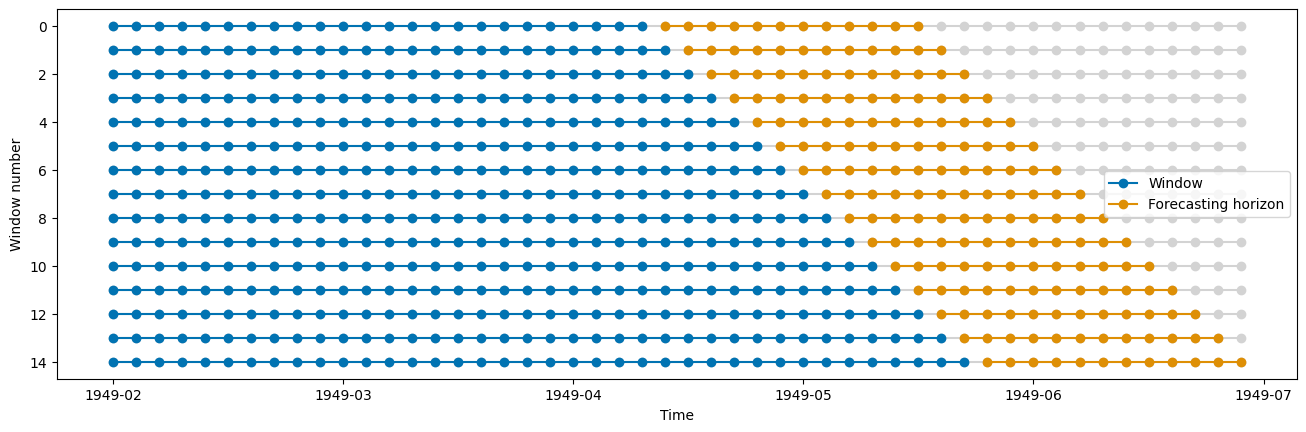

In [19]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

cv = ExpandingWindowSplitter(step_length=1, fh=fh, initial_window=24)
plot_windows(cv, y.iloc[:50])

#

#### Probabilistic forecasting for multivariate and hierarchical data

multivariate data: first column index for different variables

In [20]:
from sktime.datasets import load_longley
from sktime.forecasting.var import VAR

_, y = load_longley()

mv_forecaster = VAR()

mv_forecaster.fit(y, fh=[1, 2, 3])
# mv_forecaster.predict_var()

VAR()

hierarchical data: probabilistic forecasts per level are row-concatenated with a row hierarchy index

In [21]:
from sktime.forecasting.arima import ARIMA
from sktime.utils._testing.hierarchical import _make_hierarchical

y_hier = _make_hierarchical()
y_hier

c0
h0   h1   time                
h0_0 h1_0 2000-01-01  1.725244
          2000-01-02  2.078685
          2000-01-03  4.406164
          2000-01-04  2.486325
          2000-01-05  2.847745
...                        ...
h0_1 h1_3 2000-01-08  4.198483
          2000-01-09  3.730936
          2000-01-10  3.540454
          2000-01-11  3.444249
          2000-01-12  3.831466

[96 rows x 1 columns]

In [22]:
forecaster = ARIMA()
forecaster.fit(y_hier, fh=[1, 2, 3])
forecaster.predict_interval()

0          
                           0.9          
                         lower     upper
h0   h1   time                          
h0_0 h1_0 2000-01-13  1.547240  5.656626
          2000-01-14  1.486515  6.111832
          2000-01-15  1.524294  6.277836
     h1_1 2000-01-13  3.285397  5.304444
          2000-01-14  3.357664  5.387562
          2000-01-15  3.349540  5.379555
     h1_2 2000-01-13  2.916079  6.618686
          2000-01-14  2.920492  6.653291
          2000-01-15  2.922742  6.656034
     h1_3 2000-01-13  2.830648  5.936913
          2000-01-14  2.753652  5.974169
          2000-01-15  2.744015  5.972928
h0_1 h1_0 2000-01-13  2.371798  4.871334
          2000-01-14  2.447080  5.252941
          2000-01-15  2.526418  5.406628
     h1_1 2000-01-13  2.648028  5.302283
          2000-01-14  2.673720  5.360916
          2000-01-15  2.679975  5.367988
     h1_2 2000-01-13  3.541852  5.942392
          2000-01-14  3.423455  5.869728
          2000-01-15  3.441320  5.889336
     h1_3 2000-01-13  3.150096  5.231645
          2000-01-14  2.981736  5.161234
          2000-01-15  3.014187  5.202889

(more about this in the hierarchical forecasting notebook)

---
### Metrics for probabilistic forecasts and evaluation


#### overview - theory

Predicted `y` has different form from true `y`, so metrics have form

`metric(y_true: series, y_pred: proba_prediction) -> float`

where `proba_prediction` is the type of the specific "probabilistic prediction type".

I.e., we have the following function signature for a loss/metric $L$:

| Name | param | prediction/estimate of | general form |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `metric(y_true, y_pred)` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `metric(y_pred, y_pt, y_var)` (requires point forecast too) |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `metric(y_true, y_quantiles, alpha)` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `metric(y_true, y_interval, c)` |
| distribution forecast | | the law/distribution of $y'\|y$ | `metric(y_true, y_distribution)` |


#### metrics: general signature and averaging

intro using the example of the quantile loss aka interval loss aka pinball loss, in the univariate case.

For one quantile value $\alpha$, the (per-sample) pinball loss function is defined as\
$L_{\alpha}(\widehat{y}, y) := \alpha \cdot \Theta (y - \widehat{y}) + (1-\alpha) \cdot \Theta (\widehat{y} - y)$,\
where $\Theta (x) := [1$ if $x\ge 0$ and $0$ otherwise $]$ is the Heaviside function.

This can be used to evaluate:

* *multiple quantile* forecasts $\widehat{\bf y}:=\widehat{y}_1, \dots, \widehat{y}_k$ for quantiles $\bm{\alpha} = \alpha_1,\dots, \alpha_k$ via\
$L_{\bm{\alpha}}(\widehat{\bf y}, y) := \frac{1}{k}\sum_{i=1}^k L_{\alpha_i}(\widehat{y}_i, y)$
* *interval forecasts* $[\widehat{a}, \widehat{b}]$ at symmetric coverage $c$ via\
$L_c([\widehat{a},\widehat{b}], y) := \frac{1}{2} L_{\alpha_{low}}(\widehat{a}, y) + \frac{1}{2}L_{\alpha_{high}}(\widehat{b}, y)$ where $\alpha_{low} = \frac{1-c}{2}, \alpha_{high} = \frac{1+c}{2}$

(all are known to be strictly proper losses for their respective prediction object)

There are *three things we can choose to average over*:

* quantile values, if multiple are predicted - elements of `alpha` in `predict_interval(fh, alpha)`
* time stamps in the forecasting horizon `fh` - elements of `fh` in `fit(fh)` resp `predict_interval(fh, alpha)`
* variables in `y`, in case of multivariate (later, first we look at univariate)

We will show quantile values and time stamps first:

1. averaging by `fh` time stamps only -> one number per quantile value in `alpha`

2. averaging over nothing -> one number per quantile value in `alpha` and `fh` time stamp

3. averaging over both `fh` and quantile values in `alpha` -> one number


first, generating some quantile predictions.
`pred_quantiles` now contains quantile forecasts\
formally, forecasts $\widehat{y}_j(t_i)$ where $\widehat{y_j}$ are forecasts at quantile $\alpha_j$, with range $i=1\dots N, j=1\dots k$\
$\alpha_j$ are the elements of `alpha`, and $t_i$ are the future time stamps indexed by `fh`

In [22]:
import numpy as np

from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

y_train = load_airline()[0:24]  # train on 24 months, 1949 and 1950
y_test = load_airline()[24:36]  # ground truth for 12 months in 1951

# try to forecast 12 months ahead, from y_train
fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train, fh=fh)

pred_quantiles = forecaster.predict_quantiles(alpha=[0.1, 0.25, 0.5, 0.75, 0.9])
pred_quantiles

Number of airline passengers                                      \
                                0.10        0.25        0.50        0.75   
1951-01                   127.478982  130.438212  133.726132  137.014051   
1951-02                   137.638273  141.120018  144.988491  148.856963   
1951-03                   152.276580  156.212068  160.584681  164.957294   
1951-04                   143.405971  147.748041  152.572397  157.396752   
1951-05                   130.762062  135.475775  140.713052  145.950329   
1951-06                   155.995358  161.053480  166.673421  172.293362   
1951-07                   170.413964  175.794494  181.772655  187.750815   
1951-08                   169.718562  175.403245  181.719341  188.035437   
1951-09                   154.000332  159.973701  166.610547  173.247393   
1951-10                   132.362640  138.611371  145.554166  152.496960   
1951-11                   113.464721  119.977182  127.213000  134.448818   
1951-12                   129.690414  136.456333  143.973761  151.491189   

                     
               0.90  
1951-01  139.973281  
1951-02  152.338709  
1951-03  168.892782  
1951-04  161.738823  
1951-05  150.664042  
1951-06  177.351484  
1951-07  193.131346  
1951-08  193.720120  
1951-09  179.220762  
1951-10  158.745692  
1951-11  140.961280  
1951-12  158.257109

1. computing the loss by quantile point or interval end, averaged over `fh` time stamps\
i.e., $\frac{1}{N} \sum_{i=1}^N L_{\alpha}(\widehat{y}(t_i), y(t_i))$ for $t_i$ in the `fh`, and every `alpha`,
this is one number per quantile value in `alpha`

In [23]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

loss = PinballLoss(score_average=False)
loss(y_true=y_test, y_pred=pred_quantiles)

0.10    2.706601
0.25    5.494502
0.50    8.162432
0.75    8.003790
0.90    5.220235
Name: 0, dtype: float64

2. computing the the individual loss values, by sample, no averaging,\
i.e., $L_{\alpha}(\widehat{y}(t_i), y(t_i))$ for every $t_i$ in `fh` and every $\alpha$ in `alpha`\
this is one number per quantile value $\alpha$ in `alpha` and time point $t_i$ in `fh`

In [24]:
loss.evaluate_by_index(y_true=y_test, y_pred=pred_quantiles)

,0.10,0.25,0.50,0.75,0.90
0,1.752102,3.640447,5.636934,5.989462,4.524047
1,1.236173,2.219995,2.505755,0.857278,0.233871
2,2.572342,5.446983,8.707660,9.782030,8.196497
3,1.959403,3.812990,5.213802,4.202436,1.135059
4,4.123794,9.131056,15.643474,19.537253,19.202362
5,2.200464,4.236630,5.663290,4.279979,0.583664
6,2.858604,5.801376,8.613673,8.436889,5.281789
7,2.928144,5.899189,8.640329,8.223422,4.751892
8,2.999967,6.006575,8.694726,8.064455,4.301314
9,2.963736,5.847157,8.222917,7.127280,2.928877


3. computing the loss for a multiple quantile forecast, averaged over `fh` time stamps and quantile values `alpha`\
i.e., $\frac{1}{Nk} \sum_{j=1}^k\sum_{i=1}^N L_{\alpha_j}(\widehat{y_j}(t_i), y(t_i))$ for $t_i$ in `fh`, and quantile values $\alpha_j$,\
this is a single number that can be used in tuning (e.g., grid search) or evaluation overall

In [25]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

loss_multi = PinballLoss(score_average=True)
loss_multi(y_true=y_test, y_pred=pred_quantiles)

5.917511873790087

4. computing the loss for a multiple quantile forecast, averaged quantile values `alpha`, for individual time stamps\
i.e., $\frac{1}{k} \sum_{j=1}^k L_{\alpha_j}(\widehat{y_j}(t_i), y(t_i))$ for $t_i$ in `fh`, and quantile values $\alpha_j$,\
this is a univariate time series at `fh` times $t_i$, it can be used for tuning or evaluation by horizon index

In [26]:
loss_multi.evaluate_by_index(y_true=y_test, y_pred=pred_quantiles)

0      4.308598
1      1.410614
2      6.941102
3      3.264738
4     13.527588
5      3.392805
6      6.198466
7      6.088595
8      6.013407
9      5.417993
10     6.470193
11     7.976041
dtype: float64

Question: why is `score_average` a constructor flag, and `evaluate_by_index` a method?

* not all losses are "by index", so `evaluate_by_index` logic can vary (e.g., pseudo-samples)
* constructor args define "mathematical object" of scientific signature: series -> non-temporal object\
methods define action or "way to apply", e.g., as used in tuning or reporting

Compare `score_average` to `multioutput` arg in `scikit-learn` metrics and `sktime`.

#### metrics: interval vs quantile metrics

Interval and quantile metrics can be used interchangeably:

internally, these are easily convertible to each other\
recall: lower/upper interval = quantiles at $\frac{1}{2} \pm \frac{1}2$ `coverage`

In [27]:
pred_interval = forecaster.predict_interval(coverage=0.8)
pred_interval

Number of airline passengers            
                                 0.8            
                               lower       upper
1951-01                   127.478982  139.973281
1951-02                   137.638273  152.338709
1951-03                   152.276580  168.892782
1951-04                   143.405971  161.738823
1951-05                   130.762062  150.664042
1951-06                   155.995358  177.351484
1951-07                   170.413964  193.131346
1951-08                   169.718562  193.720120
1951-09                   154.000332  179.220762
1951-10                   132.362640  158.745692
1951-11                   113.464721  140.961280
1951-12                   129.690414  158.257109

loss object recognizes input type automatically and computes corresponding interval loss

In [28]:
loss(y_true=y_test, y_pred=pred_interval)

0.1    2.706601
0.9    5.220235
Name: 0, dtype: float64

In [30]:
loss_multi(y_true=y_test, y_pred=pred_interval)

3.9634182197580174

#### evaluation by backtesting

In [31]:
from sktime.datasets import load_airline
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

# 1. define data
y = load_airline()

# 2. define splitting/backtesting regime
fh = [1, 2, 3]
cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=72)

# 3. define loss to use
loss = PinballLoss()
# default is score_average=True and multi_output="uniform_average", so gives a number

forecaster = ThetaForecaster(sp=12)
results = evaluate(
    forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True, scoring=loss
)
results.iloc[:, :5].head()

,test_PinballLoss,fit_time,pred_time,len_train_window,cutoff
0,0.865788,0.005785,0.005240,72,1954-12
1,0.958340,0.004488,0.004102,84,1955-12
2,0.981744,0.004528,0.003721,96,1956-12
3,1.411309,0.003763,0.003200,108,1957-12
4,1.187198,0.003296,0.003038,120,1958-12


* each row is one train/test split in the walkforward setting
* first col is the loss on the test fold
* last two columns summarize length of training window, cutoff between train/test

roadmap items:

implementing further metrics

* distribution prediction metrics - may need tfp extension
* advanced evaluation set-ups
* variance loss

contributions are appreciated!

---
### Advanced composition: pipelines, tuning, reduction, adding proba forecasts to any estimator


composition = constructing "composite" estimators out of multiple "component" estimators

* **reduction** = building estimator type A using estimator type B
    * special case: adding proba forecasting capability to non-proba forecaster
    * special case: using proba supervised learner for  proba forecasting
* **pipelining** = chaining estimators, here: transformers to a forecaster
* **tuning** = automated hyper-parameter fitting, usually via internal evaluation loop
    * special case: grid parameter search and random parameter search tuning
    * special case: "Auto-ML", optimizing not just estimator hyper-parameter but also choice of estimator

#### Adding probabilistic forecasts to non-probabilistic forecasters

start with a forecaster that does not produce probabilistic predictions:

In [32]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

my_forecaster = ExponentialSmoothing()

# does the forecaster support probabilistic predictions?
my_forecaster.get_tag("capability:pred_int")

False

adding probabilistic predictions is possible via reduction wrappers:

In [33]:
# NaiveVariance adds intervals & variance via collecting past residuals
from sktime.forecasting.naive import NaiveVariance

# create a composite forecaster like this:
my_forecaster_with_proba = NaiveVariance(my_forecaster)

# does it support probabilistic predictions now?
my_forecaster_with_proba.get_tag("capability:pred_int")

True

the composite can now be used like any probabilistic forecaster:

In [34]:
y = load_airline()

my_forecaster_with_proba.fit(y, fh=[1, 2, 3])
my_forecaster_with_proba.predict_interval()

Number of airline passengers            
                                 0.9            
                               lower       upper
1961-01                   341.960792  522.039207
1961-02                   319.835453  544.164546
1961-03                   307.334056  556.665943

roadmap items:

more compositors to enable probabilistic forecasting

* bootstrap forecast intervals
* reduction to probabilistic supervised learning
* popular "add probabilistic capability" wrappers

contributions are appreciated!

#### Tuning and AutoML 

tuning and autoML with probabilistic forecasters works exactly like with "ordinary" forecasters\
via `ForecastingGridSearchCV` or `ForecastingRandomSearchCV`

* change metric to tune to a probabilistic metric
* use a corresponding probabilistic metric or loss function

Internally, evaluation will be done using probabilistic metric, via backtesting evaluation.

**important**: to evaluate the tuned estimator, use it in `evaluate` or a separate benchmarking workflow.\
Using internal metric/loss values amounts to in-sample evaluation, which is over-optimistic.

In [35]:
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

# forecaster we want to tune
forecaster = ThetaForecaster()

# parameter grid to search over
param_grid = {"sp": [1, 6, 12]}

# evaluation/backtesting regime for *tuning*
fh = [1, 2, 3]  # fh for tuning regime, does not need to be same as in fit/predict!
cv = SlidingWindowSplitter(window_length=36, fh=fh)
scoring = PinballLoss()

# construct the composite forecaster with grid search compositor
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=param_grid, scoring=scoring, strategy="refit"
)

In [36]:
from sktime.datasets import load_airline

y = load_airline()[:60]

gscv.fit(y, fh=fh)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=[1, 2, 3],
                                                 window_length=36),
                        forecaster=ThetaForecaster(),
                        param_grid={'sp': [1, 6, 12]}, scoring=PinballLoss())

inspect hyper-parameter fit obtained by tuning:

In [37]:
gscv.best_params_

{'sp': 12}

obtain predictions:

In [38]:
gscv.predict_interval()

Number of airline passengers            
                                 0.9            
                               lower       upper
1954-01                   190.832917  217.164705
1954-02                   195.638436  226.620355
1954-03                   221.947952  256.967883

for AutoML, use the `MultiplexForecaster` to select among multiple forecasters:

In [39]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster, NaiveVariance

forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)

forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y)
gscv.best_params_

{'selected_forecaster': 'naive'}

#### Pipelines with probabilistic forecasters

`sktime` pipelines are compatible with probabilistic forecasters:

* `ForecastingPipeline` applies transformers to the exogeneous `X` argument before passing them to the forecaster
* `TransformedTargetForecaster` transforms `y` and back-transforms forecasts, including interval or quantile forecasts

`ForecastingPipeline` takes a chain of transformers and forecasters, say,

`[t1, t2, ..., tn, f]`,

where `t[i]` are forecasters that pre-process, and `tp[i]` are forecasters that postprocess

##### `fit(y, X, fh)` does:

`X1 = t1.fit_transform(X)`\
`X2 = t2.fit_transform(X1)`\
etc\
`X[n] = t3.fit_transform(X[n-1])`\

`f.fit(y=y, x=X[n])`

##### `predict_[sth](X, fh)` does:

`X1 = t1.transform(X)`\
`X2 = t2.transform(X1)`\
etc\
`X[n] = t3.transform(X[n-1])`

`f.predict_[sth](X=X[n], fh)`

In [40]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.impute import Imputer

In [41]:
data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [42]:
forecaster = ForecastingPipeline(
    steps=[
        ("imputer", Imputer(method="mean")),
        ("forecaster", ARIMA(suppress_warnings=True)),
    ]
)
forecaster.fit(y=y_train, X=X_train, fh=X_test.index[:5])
forecaster.predict_interval(X=X_test[:5])

0          
             0.9          
           lower     upper
Period                    
1997Q1  5.042704  6.119990
1997Q2  3.948564  5.235163
1997Q3  3.887471  5.253592
1997Q4  4.108211  5.506862
1998Q1  4.501319  5.913611

`TransformedTargetForecaster` takes a chain of transformers and forecasters, say,

`[t1, t2, ..., tn, f, tp1, tp2, ..., tk]`,

where `t[i]` are forecasters that pre-process, and `tp[i]` are forecasters that postprocess

##### `fit(y, X, fh)` does:\
`y1 = t1.fit_transform(y)`\
`y2 = t2.fit_transform(y1)`\
`y3 = t3.fit_transform(y2)`\
etc\
`y[n] = t3.fit_transform(y[n-1])`

`f.fit(y[n])`

`yp1 = tp1.fit_transform(yn)`\
`yp2 = tp2.fit_transform(yp1)`\
`yp3 = tp3.fit_transform(yp2)`\
etc

##### `predict_quantiles(y, X, fh)` does:

`y1 = t1.transform(y)`\
`y2 = t2.transform(y1)`\
etc\
`y[n] = t3.transform(y[n-1])`

`y_pred = f.predict_quantiles(y[n])`

`y_pred = t[n].inverse_transform(y_pred)`\
`y_pred = t[n-1].inverse_transform(y_pred)`\
etc\
`y_pred = t1.inverse_transform(y_pred)`\
`y_pred = tp1.transform(y_pred)`\
`y_pred = tp2.transform(y_pred)`\
etc\
`y_pred = tp[n].transform(y_pred)`\

**Note**: the remaining proba predictions are inferred from `predict_quantiles`.

In [43]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

In [44]:
data = load_macroeconomic()
y = data[["unemp"]]

In [45]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(sp=12)),
        ("detrend", Detrender()),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y, fh=[1, 2, 3])
forecaster.predict_interval()

0           
             0.9           
           lower      upper
2009Q4  8.949103  10.068284
2010Q1  8.639806  10.206350
2010Q2  8.438112  10.337207

In [46]:
forecaster.predict_quantiles()

0           
            0.05       0.95
2009Q4  8.949103  10.068284
2010Q1  8.639806  10.206350
2010Q2  8.438112  10.337207

quick creation also possible via the `*` dunder method, same pipeline:

In [47]:
forecaster = Deseasonalizer(sp=12) * Detrender() * ARIMA()

In [48]:
forecaster.fit(y, fh=[1, 2, 3])
forecaster.predict_interval()

0           
             0.9           
           lower      upper
2009Q4  8.949103  10.068284
2010Q1  8.639806  10.206350
2010Q2  8.438112  10.337207

---
## Building your own probabilistic forecaster

Getting started:

* follow the ["implementing estimator" developer guide](https://www.sktime.net/en/stable/developer_guide/add_estimators.html)
* use the advanced [forecasting extension template](https://github.com/sktime/sktime/blob/main/extension_templates/forecasting.py)

Extension template = python "fill-in" template with to-do blocks that allow you to implement your own, sktime-compatible forecasting algorithm.

Check estimators using `check_estimator`

For probabilistic forecasting:

* implement at least one of `predict_quantiles`, `predict_interval`, `predict_var`, `predict_proba`
* optimally, implement all, unless identical with defaulting behaviour as below
* if only one is implemented, others use following defaults (in this sequence, dependent availability):
    * `predict_interval` uses quantiles from `predict_quantiles` and vice versa
    * `predict_var` uses variance from `predict_proba`, or variance of normal with IQR as obtained from `predict_quantiles`
    * `predict_interval` or `predict_quantiles` uses quantiles from `predict_proba` distribution
    * `predict_proba` returns normal with mean `predict` and variance `predict_var`
* so if predictive residuals not normal, implement `predict_proba` or `predict_quantiles`
* if interfacing, implement the ones where least "conversion" is necessary
* ensure to set the `capability:pred_int` tag to `True`


In [49]:
# estimator checking on the fly using check_estimator

# suppose NaiveForecaster is your new estimator
from sktime.forecasting.naive import NaiveForecaster

# check the estimator like this

# uncomment this block to run

# from sktime.utils.estimator_checks import check_estimator
#
# check_estimator(NaiveForecaster)

# this prints any failed tests, and returns dictionary with
#   keys of test runs and results from the test run
# run individual tests using the tests_to_run arg or the fixtures_to_run_arg
#   these need to be identical to test or test/fixture names, see docstring

In [50]:
# to raise errors for use in traceback debugging:

# uncomment next line to run
# check_estimator(NaiveForecaster, raise_exceptions=True)

# this does not raise an error since NaiveForecaster is fine, but would if it weren't

---
## Summary

* unified API for probabilistic forecasting and probabilistic metrics
* integrating other packages (e.g. scikit-learn, statsmodels, pmdarima, prophet)
* interface for composite model building is same, proba or not (pipelining, ensembling, tuning, reduction)
* easily extensible with custom estimators

### Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).


### Credits

notebook creation: fkiraly

probablistic forecasting framework: fkiraly, kejsitake\
probabilistic metrics, tuning: eenticott-shell, fkiraly\
probabilistic estimators: aiwalter, fkiraly, ilyasmoutawwakil, k1m190r, kejsitake